This notebook is adapted from https://github.com/fdalvi/NeuroX/blob/master/examples/End%20to%20End%20Example.ipynb

# Imports

In [1]:
import numpy as np

# Add these lines if you clone from https://github.com/fdalvi/NeuroX
# import sys
# sys.path.append("/path/to/NeuroX")
# In the case of the notebook, the path is the parent directory
import sys
sys.path.append("..")

# Data

In [5]:
!wget http://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz -O - | gunzip | cut -f1,2 -d" " > pos.train.txt 
!wget http://www.cnts.ua.ac.be/conll2000/chunking/test.txt.gz -O - | gunzip | cut -f1,2 -d " " > pos.test.txt

--2022-11-14 08:57:10--  http://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz
Resolving www.cnts.ua.ac.be (www.cnts.ua.ac.be)... 146.175.13.81
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|146.175.13.81|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz [following]
--2022-11-14 08:57:10--  https://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|146.175.13.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611540 (597K) [application/x-gzip]
Saving to: 'STDOUT'

-                   100%[===================>] 597.21K  1.21MB/s    in 0.5s    

2022-11-14 08:57:11 (1.21 MB/s) - written to stdout [611540/611540]

--2022-11-14 08:57:11--  http://www.cnts.ua.ac.be/conll2000/chunking/test.txt.gz
Resolving www.cnts.ua.ac.be (www.cnts.ua.ac.be)... 146.175.13.81
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|

In [6]:
def preprocessing(fin, fout):
    fout_text = open(fout+'.text', 'w', encoding='utf-8')
    fout_tag = open(fout+'.tag', 'w', encoding='utf-8')
    sent_text = []
    sent_tag = []
    with open(fin, 'r', encoding='utf-8') as f:
        for line in f:
            if line != '\n':
                [text, tag] = line.split()
                sent_text.append(text)
                sent_tag.append(tag)
            else:
                sent_text.append('\n')
                sent_tag.append('\n')
                fout_text.write(' '.join(sent_text))
                fout_tag.write(' '.join(sent_tag))
                sent_text = []
                sent_tag = []
        fout_text.close()
        fout_tag.close()
        

In [7]:
preprocessing('pos.train.txt', 'train')
preprocessing('pos.test.txt', 'test')

# Extract Representations

In [8]:
import neurox.data.extraction.transformers_extractor as transformers_extractor

In [11]:
# you can run the following command in terminal to avoid verbose output in notebook
# python -m neurox.data.extraction.transformers_extractor --filter_layers 0 bert-base-uncased train.text train_activation.json

# transformers_extractor.extract_representations('bert-base-uncased',
#     'train.text',
#     'train_activation.json',
#     device = 'cuda',
#     aggregation="average", #last, first
#     filter_layers = [0]
# )

In [10]:
! cut -c1-120 < train_activation.json

{"linex_index": 0, "features": [{"token": "confidence", "layers": [{"index": 0, "values": [0.55443066, 0.57546091, -0.58
{"linex_index": 1, "features": [{"token": "chancellor", "layers": [{"index": 0, "values": [-0.10590585, -1.0280143, -0.6
{"linex_index": 2, "features": [{"token": "but", "layers": [{"index": 0, "values": [0.37906024, 0.5005427, -0.0606893, 0
{"linex_index": 3, "features": [{"token": "this", "layers": [{"index": 0, "values": [-0.64851344, 0.67392409, -0.0932498
{"linex_index": 4, "features": [{"token": "``", "layers": [{"index": 0, "values": [-0.73166448, 0.1452198, -0.77601731, 
{"linex_index": 5, "features": [{"token": "``", "layers": [{"index": 0, "values": [-0.73166448, 0.1452198, -0.77601731, 
{"linex_index": 6, "features": [{"token": "forecast##s", "layers": [{"index": 0, "values": [-0.79362893, -0.15296265, 0.
{"linex_index": 7, "features": [{"token": "the", "layers": [{"index": 0, "values": [-0.43669656, 0.53601712, -0.05141335
{"linex_index": 8, "features": [

# Prepare Data

In [2]:
import neurox.data.loader as data_loader
activations, num_layers = data_loader.load_activations('train_activation.json', 768)

Loading json activations from train_activation.json...
8936 1.0


In [3]:
print(len(activations))

8936


In [4]:
activations[0].shape

(37, 768)

In [5]:
activations[1].shape

(27, 768)

In [6]:
# load_data also does sanity checks for parallelism between tokens, labels and activations
tokens = data_loader.load_data('train.text',
                               'train.tag',
                               activations,
                               512 # max_sent_l
                              )

In [7]:
import neurox.interpretation.utils as utils
X, y, mapping = utils.create_tensors(tokens, activations, 'NN')
label2idx, idx2label, src2idx, idx2src = mapping

Number of tokens:  211727
length of source dictionary:  19122
length of target dictionary:  44
211727
Total instances: 211727
['Still', 'swelled', '2,610', 'Hispanic', 'prime', 'GM', 'Kremlin', 'anonymity', 'Damascus', '754', 'NOTE', 'unworthy', 'elected', 'Essex', 'foundering', '60.1', 'storm', 'WHAT', 'Securities', 'steadfastly']
Number of samples:  211727
Stats: Labels with their frequencies in the final set
PRP$ 1881
NNPS 420
IN 22764
NN 30147
$ 1750
RBS 191
'' 1493
VBD 6745
. 8827
VBN 4763
: 1047
DT 18335
`` 1531
NNP 19884
JJ 13085
) 281
# 36
VB 6017
POS 1769
WDT 955
RB 6607
NNS 13619
EX 206
PRP 3820
JJS 374
( 274
VBG 3272
MD 2167
RP 83
CD 8315
SYM 6
JJR 853
RBR 321
VBZ 4648
UH 15
, 10770
CC 5372
WP$ 35
WRB 478
FW 38
WP 529
VBP 2868
TO 5081
PDT 55


In [8]:
X.shape

(211727, 768)

In [9]:
print(mapping[0])

{'PRP$': 0, 'NNPS': 1, 'IN': 2, 'NN': 3, '$': 4, 'RBS': 5, "''": 6, 'VBD': 7, '.': 8, 'VBN': 9, ':': 10, 'DT': 11, '``': 12, 'NNP': 13, 'JJ': 14, ')': 15, '#': 16, 'VB': 17, 'POS': 18, 'WDT': 19, 'RB': 20, 'NNS': 21, 'EX': 22, 'PRP': 23, 'JJS': 24, '(': 25, 'VBG': 26, 'MD': 27, 'RP': 28, 'CD': 29, 'SYM': 30, 'JJR': 31, 'RBR': 32, 'VBZ': 33, 'UH': 34, ',': 35, 'CC': 36, 'WP$': 37, 'WRB': 38, 'FW': 39, 'WP': 40, 'VBP': 41, 'TO': 42, 'PDT': 43}


In [10]:
X[0].shape 

(768,)

train_val split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
X_train.shape

(158795, 768)

In [14]:
X_train.shape[0]/X_test.shape[0]

2.9999811078364695

# Train Probing Classifier

In [15]:
import neurox.interpretation.linear_probe as linear_probe

In [17]:
probe = linear_probe.train_logistic_regression_probe(X_train, y_train, lambda_l1=0.001, lambda_l2=0.001, num_epochs=10, batch_size=128)

Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0082


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0067


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0065


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0064


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0064


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0064


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0063


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0063


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0063


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0063


# Evaluate Model

In [19]:
scores = linear_probe.evaluate_probe(probe, X_test, y_test, idx_to_class=idx2label)
scores

Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.89


{'__OVERALL__': 0.8874027053578176,
 'PRP$': 1.0,
 'NNPS': 0.0,
 'IN': 0.9895433949111189,
 'NN': 0.9067540983606558,
 '$': 1.0,
 'RBS': 0.0,
 "''": 1.0,
 'VBD': 0.8377752027809965,
 '.': 0.9910913140311804,
 'VBN': 0.7146401985111662,
 ':': 0.8273381294964028,
 'DT': 0.987137562677131,
 '``': 1.0,
 'NNP': 0.6693580944691159,
 'JJ': 0.77125,
 ')': 0.0,
 '#': 0.0,
 'VB': 0.672285906945381,
 'POS': 0.9296116504854369,
 'WDT': 0.5260869565217391,
 'RB': 0.9080664294187426,
 'NNS': 0.9795918367346939,
 'EX': 1.0,
 'PRP': 0.9957582184517497,
 'JJS': 0.2463768115942029,
 '(': 0.0,
 'VBG': 0.8235294117647058,
 'MD': 0.9641509433962264,
 'RP': 0.0,
 'CD': 0.9847619047619047,
 'SYM': nan,
 'JJR': 0.8520408163265306,
 'RBR': 0.0,
 'VBZ': 0.7928692699490663,
 'UH': 0.0,
 ',': 1.0,
 'CC': 0.9935205183585313,
 'WP$': 0.0,
 'WRB': 0.9122807017543859,
 'FW': 0.0,
 'WP': 1.0,
 'VBP': 0.6150506512301013,
 'TO': 0.9992088607594937,
 'PDT': 0.0}

# Get Neuron Ranking

In [20]:
ordering, cutoffs = linear_probe.get_neuron_ordering(probe, label2idx)

  0%|          | 0/101 [00:00<?, ?it/s]

In [21]:
ordering[:10]

[644, 519, 653, 409, 666, 413, 541, 30, 290, 295]

In [23]:
weights = list(probe.parameters())[0].data.cpu()
weights = np.abs(weights.numpy())

In [24]:
weights.shape

(44, 768)

In [28]:
import matplotlib.pyplot as plt

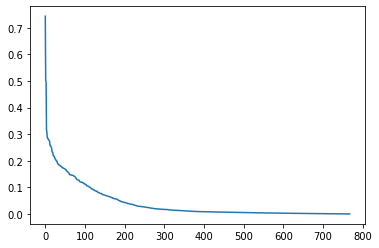

In [36]:
# plot weights distribution of NN
plt.plot(np.sort(weights[label2idx['NN']])[::-1])
plt.savefig('weights distribution of label NN')

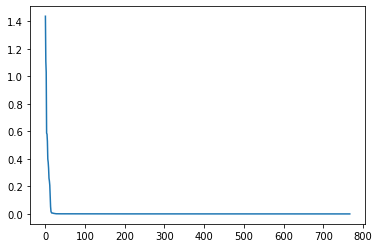

In [37]:
# plot weights distribution of POS
plt.plot(np.sort(weights[label2idx[',']])[::-1])
plt.savefig('weights distribution of label ,')

# Train on top N neurons

In [42]:
import neurox.interpretation.ablation as ablation

In [52]:
def train_on_neurons(X, y, ordering, percentage, mode, idx2label=None):
    total = X.shape[1]
    N = np.floor(total*percentage).astype(int)
    if mode == 'top':
        keep_neurons = ordering[:N]
    elif mode == 'bottom':
        keep_neurons = ordering[-N:]
    else:
        print('keep should be top or bottom!')
    X_selected = ablation.filter_activations_keep_neurons(X, keep_neurons)
    print(X_selected.shape)
    X_selected_train, X_selected_test, y_selected_train, y_selected_test = train_test_split(X_selected, y)
    probe_selected = linear_probe.train_logistic_regression_probe(X_selected_train, y_selected_train, lambda_l1=0.001, lambda_l2=0.001, batch_size=256)
    scores = linear_probe.evaluate_probe(probe_selected, X_selected_test, y_selected_test, idx_to_class=idx2label)
    return scores

In [62]:
def compute_score(mode):
    scores = []
    for i in range(1,21,1):
        percentage = i/100
        score = train_on_neurons(X,y,ordering,percentage,mode, idx2label)
        scores.append(score)
    return scores

In [63]:
scores_from_top = compute_score('top')

(211727, 7)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0131


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0107


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0101


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0098


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0097


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0096


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0095


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0095


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0094


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0094


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.35
(211727, 15)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0110


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0082


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0074


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0071


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0069


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0068


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0067


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0066


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0066


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0066


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.57
(211727, 23)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/neurox/interpretation/metrics.py:49: RuntimeWarning: Mean of empty slice.
  return (preds == labels).mean()
/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0106


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0074


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0067


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0063


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0062


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0061


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0060


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0059


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0059


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0059


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.64
(211727, 30)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0096


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0067


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0061


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0059


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0057


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0056


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0056


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0055


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0055


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0055


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.67
(211727, 38)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0093


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0064


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0058


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0055


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0054


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0053


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0052


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0052


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0052


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0051


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.69
(211727, 46)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0090


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0060


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0055


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0053


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0051


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0051


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0050


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0049


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0049


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0049


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.71
(211727, 53)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0088


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0059


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0054


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0052


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0051


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0050


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0049


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0049


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0048


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0048


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.73
(211727, 61)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0085


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0058


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0053


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0051


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0049


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0049


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0048


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0048


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0047


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0047


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.73
(211727, 69)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0081


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0055


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0050


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0049


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0048


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0047


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0046


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0046


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0046


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0046


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.75
(211727, 76)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0080


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0053


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0049


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0047


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0046


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0046


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0045


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0045


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0045


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0044


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.76
(211727, 84)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0078


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0052


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0048


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0047


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0046


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0045


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0044


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0044


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0044


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0044


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.77
(211727, 92)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0076


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0051


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0047


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0045


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0044


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0044


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0043


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0043


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0043


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0043


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.78
(211727, 99)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0074


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0050


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0046


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0045


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0044


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0043


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0043


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0042


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0042


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0042


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.79
(211727, 107)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0073


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0049


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0046


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0044


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0043


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0043


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0042


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0042


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0042


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0041


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.79
(211727, 115)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0070


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0048


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0045


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0043


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0042


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0042


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0041


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0041


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0041


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0041


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.80
(211727, 122)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0071


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0048


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0044


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0043


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0042


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0041


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0041


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0041


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0041


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0040


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.80
(211727, 130)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0069


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0046


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0043


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0042


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0041


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0041


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0040


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0040


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0040


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0040


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.81
(211727, 138)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0068


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0046


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0043


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0041


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0040


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0040


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0039


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0039


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0039


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0039


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.82
(211727, 145)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0067


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0045


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0042


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0041


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0040


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0040


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0039


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0039


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0039


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0039


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.82
(211727, 153)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0066


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0045


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0042


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0040


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0040


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0039


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0039


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0038


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0038


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0038


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.82


In [64]:
scores_from_top

[{'__OVERALL__': 0.35084636892616944,
  'PRP$': 0.0,
  'NNPS': 0.0,
  'IN': 0.7136729222520107,
  'NN': 0.525359477124183,
  '$': 0.8940677966101694,
  'RBS': 0.0,
  "''": 0.9918256130790191,
  'VBD': 0.08267954133977067,
  '.': 0.7113744075829384,
  'VBN': 0.02339688041594454,
  ':': 0.0,
  'DT': 0.6271076523994812,
  '``': 1.0,
  'NNP': 0.008077544426494346,
  'JJ': 0.06781713593702694,
  ')': 0.0,
  '#': 0.0,
  'VB': 0.004140786749482402,
  'POS': 0.0,
  'WDT': 0.16379310344827586,
  'RB': 0.0,
  'NNS': 0.1349067599067599,
  'EX': 0.0,
  'PRP': 0.003171247357293869,
  'JJS': 0.0,
  '(': 0.0,
  'VBG': 0.0,
  'MD': 0.5738007380073801,
  'RP': 0.0,
  'CD': 0.5209638554216868,
  'SYM': 0.0,
  'JJR': 0.0,
  'RBR': 0.0,
  'VBZ': 0.001736111111111111,
  'UH': 0.0,
  ',': 0.5335051546391752,
  'CC': 0.027298850574712645,
  'WP$': 0.0,
  'WRB': 0.0,
  'FW': 0.0,
  'WP': 0.0,
  'VBP': 0.0,
  'TO': 0.9340390879478827,
  'PDT': 0.0},
 {'__OVERALL__': 0.5739061437315801,
  'PRP$': 0.020920502092

In [65]:
scores_from_bottom = compute_score('bottom')

(211727, 7)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0135


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0114


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0107


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0103


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0101


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0100


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0100


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0100


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0099


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0099


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.33
(211727, 15)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0125


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0102


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0094


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0090


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0088


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0087


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0086


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0085


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0085


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0085


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.46
(211727, 23)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0120


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0094


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0087


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0083


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0081


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0080


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0079


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0079


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0078


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0078


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.51
(211727, 30)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0115


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0089


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0082


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0079


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0077


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0076


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0076


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0075


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0075


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0075


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.55
(211727, 38)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0108


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0082


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0076


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0074


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0072


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0071


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0070


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0070


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0070


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0070


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.60
(211727, 46)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0105


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0078


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0072


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0070


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0069


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0068


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0067


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0067


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0067


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0066


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.62
(211727, 53)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0103


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0075


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0070


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0067


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0066


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0065


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0064


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0064


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0064


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0063


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.64
(211727, 61)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0096


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0070


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0065


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0063


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0062


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0061


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0061


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0060


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0060


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0060


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.66
(211727, 69)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0095


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0067


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0063


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0060


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0059


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0059


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0058


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0058


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0058


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0057


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.69
(211727, 76)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0092


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0066


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0061


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0059


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0058


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0057


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0057


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0056


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0056


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0056


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.70
(211727, 84)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0090


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0064


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0059


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0057


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0056


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0056


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0055


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0055


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0055


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0055


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.72
(211727, 92)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0087


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0062


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0058


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0056


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0055


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0054


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0054


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0054


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0054


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0053


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.72
(211727, 99)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0086


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0061


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0057


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0055


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0054


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0053


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0053


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0053


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0052


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0052


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.74
(211727, 107)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0084


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0059


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0055


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0053


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0052


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0052


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0051


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0051


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0051


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0051


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.75
(211727, 115)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0082


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0058


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0054


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0053


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0052


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0051


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0051


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0051


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0050


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0050


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.76
(211727, 122)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0081


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0057


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0053


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0052


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0051


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0050


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0050


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0050


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0050


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0049


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.77
(211727, 130)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0079


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0056


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0052


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0051


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0050


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0049


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0049


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0049


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0048


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0048


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.77
(211727, 138)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0078


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0055


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0051


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0050


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0049


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0049


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0048


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0048


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0048


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0048


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.78
(211727, 145)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0076


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0054


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0051


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0049


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0048


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0048


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0048


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0047


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0047


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0047


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.79
(211727, 153)
Training classification probe
Creating model...
Number of training instances: 158795
Number of classes: 44


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0075


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0053


epoch [3/10]: 0it [00:00, ?it/s]

Epoch: [3/10], Loss: 0.0050


epoch [4/10]: 0it [00:00, ?it/s]

Epoch: [4/10], Loss: 0.0049


epoch [5/10]: 0it [00:00, ?it/s]

Epoch: [5/10], Loss: 0.0048


epoch [6/10]: 0it [00:00, ?it/s]

Epoch: [6/10], Loss: 0.0047


epoch [7/10]: 0it [00:00, ?it/s]

Epoch: [7/10], Loss: 0.0047


epoch [8/10]: 0it [00:00, ?it/s]

Epoch: [8/10], Loss: 0.0047


epoch [9/10]: 0it [00:00, ?it/s]

Epoch: [9/10], Loss: 0.0047


epoch [10/10]: 0it [00:00, ?it/s]

Epoch: [10/10], Loss: 0.0046


Evaluating: 0it [00:00, ?it/s]

Score (accuracy) of the probe: 0.80


In [66]:
scores_from_bottom

[{'__OVERALL__': 0.332690999773294,
  'PRP$': 0.0,
  'NNPS': 0.0,
  'IN': 0.4237406309918076,
  'NN': 0.43025694808599896,
  '$': 0.18584070796460178,
  'RBS': 0.0,
  "''": 0.9821882951653944,
  'VBD': 0.00117096018735363,
  '.': 0.9881682734443471,
  'VBN': 0.0,
  ':': 0.0,
  'DT': 0.8011734028683182,
  '``': 1.0,
  'NNP': 0.11120263591433278,
  'JJ': 0.031780994336060416,
  ')': 0.0,
  '#': 0.0,
  'VB': 0.0,
  'POS': 0.19015659955257272,
  'WDT': 0.0,
  'RB': 0.0,
  'NNS': 0.0005863383172090296,
  'EX': 0.0,
  'PRP': 0.0,
  'JJS': 0.0,
  '(': 0.0,
  'VBG': 0.0,
  'MD': 0.30134357005758156,
  'RP': 0.0,
  'CD': 0.35834535834535836,
  'SYM': 0.0,
  'JJR': 0.0,
  'RBR': 0.0,
  'VBZ': 0.0026431718061674008,
  'UH': 0.0,
  ',': 0.9269272926561929,
  'CC': 0.13833075734157652,
  'WP$': 0.0,
  'WRB': 0.0,
  'FW': 0.0,
  'WP': 0.0,
  'VBP': 0.0,
  'TO': 0.5869056897895557,
  'PDT': 0.0},
 {'__OVERALL__': 0.4556789843572886,
  'PRP$': 0.0,
  'NNPS': 0.0,
  'IN': 0.7513153279551035,
  'NN': 0.

In [67]:
labels = ['__OVERALL__', ',', 'NN']

In [68]:
import pandas as pd

In [71]:
df_top = pd.DataFrame.from_dict(scores_from_top)

In [73]:
df_bottom = pd.DataFrame.from_dict(scores_from_bottom)

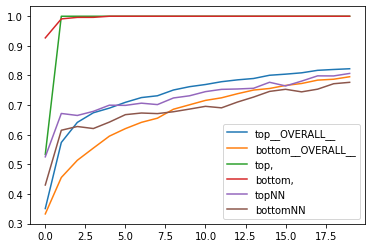

In [85]:
ax = plt.subplot()
for label in labels:
    ax.plot(df_top[label], label = 'top'+label)
    ax.plot(df_bottom[label], label = 'bottom'+label)
plt.legend()
plt.savefig('accuracy.png')